# TEST EQUIFAX

In [1]:
# # Descomentar para instalar las librerias
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install xgboost
# !pip install sklearn
# !pip install sinfo
# !pip install pickle
# !pip install scipy

In [2]:
# Se importan las librerias que se utilizaran en el proyecto
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import log_loss, make_scorer, classification_report
from sinfo import sinfo
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import pickle
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
# Visualizamos el entorno con el que se trabajo y las librerias instaladas
sinfo()

-----
data_prueba NA
google      NA
matplotlib  3.2.2
numpy       1.19.5
pandas      1.1.5
scipy       1.4.1
seaborn     0.11.1
sinfo       0.3.1
sklearn     0.22.2.post1
xgboost     0.90
-----
IPython             5.5.0
jupyter_client      5.3.5
jupyter_core        4.7.1
notebook            5.3.1
-----
Python 3.7.10 (default, Feb 20 2021, 21:17:23) [GCC 7.5.0]
Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-28 18:25


--------------

# 🎫 1. Levantar el dataset

-----------------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
# %cd /content/gdrive/MyDrive/Proyectos DS/Test Equifax

In [6]:
# !git clone https://github.com/sebastianguinazu/python_test.git

In [7]:
%cd /content/gdrive/MyDrive/Proyectos DS/Test Equifax/python_test

/content/gdrive/MyDrive/Proyectos DS/Test Equifax/python_test


In [8]:
!ls

data_prueba.py	__pycache__  README.md	Test_Equifax.ipynb  wine.csv


In [9]:
!cat data_prueba.py

def load_data():
  import pandas as pd
  import numpy as np
  import warnings
  import pandas as pd
  from pandas.core.common import SettingWithCopyWarning

  warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
  
  from sklearn.datasets import load_wine

  wine = load_wine()
  df = pd.DataFrame(data=wine['data'], columns = wine['feature_names'])
  df['target'] = wine['target']

  for var in ['alcohol', 'magnesium', 'proline']:
    df[var][np.random.choice([True, False], size=df.shape[0], p=[.2,.8])] = np.NaN
    
  df.loc[(df.target == 1),'target'] = 0
  df.loc[(df.target == 2),'target'] = 1
  
  return df

In [10]:
# Ejecutamos el script
!python data_prueba.py

In [11]:
from data_prueba import load_data

In [12]:
# Leemos el dataset y lo guardamos en la variable df
df = load_data()

---------

# 📊 2. Análisis Exploratorio

------------

In [ ]:
df.head(10)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,NaN,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,NaN,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,NaN,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,NaN,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,NaN,0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,NaN,0
8,14.83,1.64,2.17,14.0,NaN,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       143 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     147 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       141 non-null    float64
 13  targe

Vemos el tipo de datos de las features y observamos ademas que hay algunos valores nulos o faltantes.

In [ ]:
df.isna().sum()

alcohol                         35
malic_acid                       0
ash                              0
alcalinity_of_ash                0
magnesium                       31
total_phenols                    0
flavanoids                       0
nonflavanoid_phenols             0
proanthocyanins                  0
color_intensity                  0
hue                              0
od280/od315_of_diluted_wines     0
proline                         37
target                           0
dtype: int64

In [ ]:
df.describe(percentiles=[.05, .25, .5, .75, .95])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,143.000000,178.000000,178.000000,178.000000,147.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,141.000000,178.000000
mean,13.048182,2.336348,2.366517,19.494944,98.897959,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,731.659574,0.269663
std,0.830294,1.117146,0.274344,3.339564,13.171022,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,313.118207,0.445037
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
5%,11.670000,1.061000,1.920000,14.770000,80.300000,1.380000,0.545500,0.190000,0.730000,2.114000,0.570000,1.462500,345.000000,0.000000
25%,12.370000,1.602500,2.210000,17.200000,88.500000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,495.000000,0.000000
50%,13.070000,1.865000,2.360000,19.500000,97.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,650.000000,0.000000
75%,13.710000,3.082500,2.557500,21.500000,106.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,1.000000
95%,14.293000,4.455500,2.741500,25.000000,121.700000,3.274500,3.497500,0.600000,2.709000,9.598000,1.284500,3.580000,1285.000000,1.000000
max,14.830000,5.800000,3.230000,30.000000,151.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,1.000000


Hay algunos o pocos valores altos con respecto al 95% de los datos

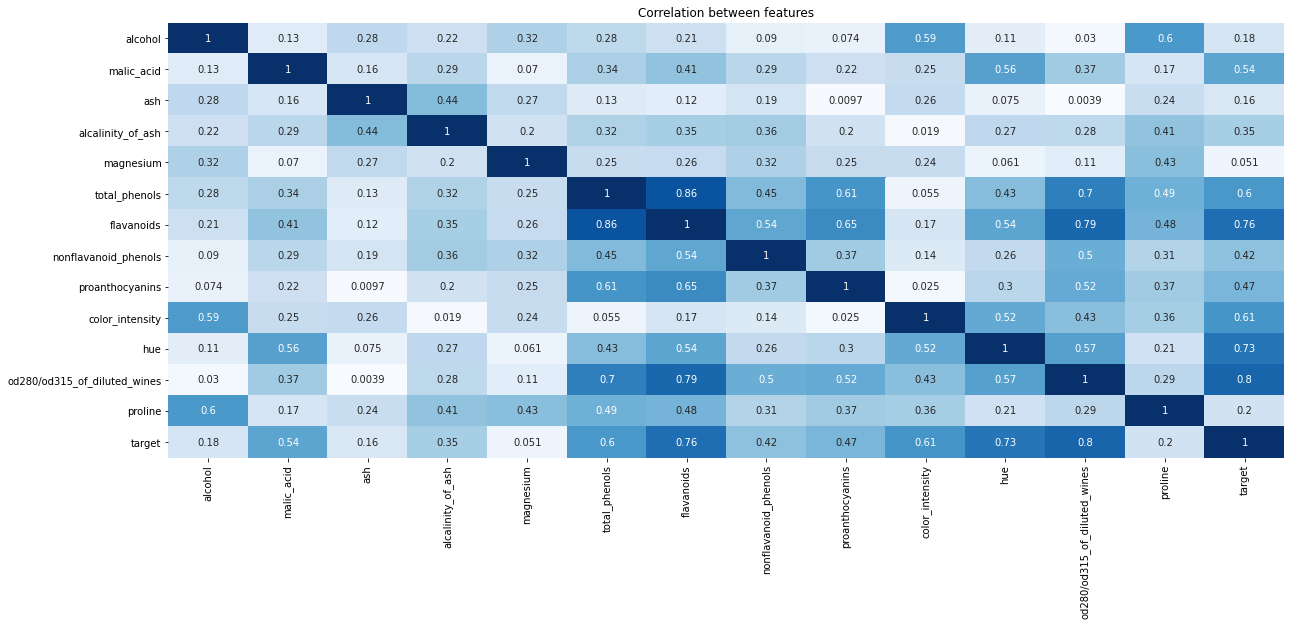

In [13]:
plt.figure(figsize=(20,8))
plt.title('Correlation between features')
sns.heatmap(df.corr().abs(), annot=True, cbar=False, cmap='Blues');

Vemos que `target` tiene correlacion con las columnas `od280/od315_of_diluted_wine`, `hue` y `flavanoids`

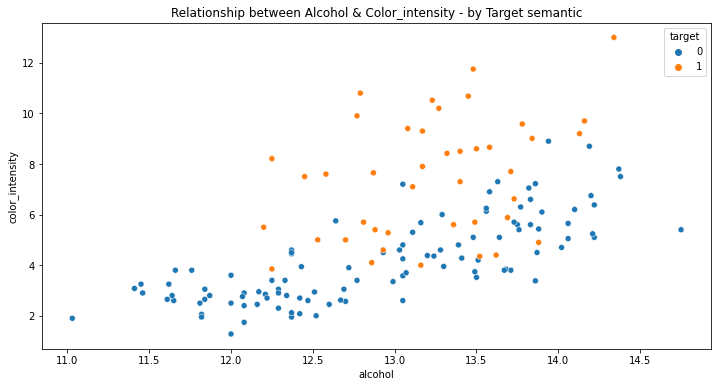

In [14]:
plt.figure(figsize=(12,6))
plt.title('Relationship between Alcohol & Color_intensity - by Target semantic')
sns.scatterplot(x=df['alcohol'], y=df['color_intensity'], hue=df['target']);

Hay relacion entre la variable `alcohol` y `color_intensity`. Ademas, los vinos que corresponden a la categoria 1 tienen un mayor valor de intensidad y un valor medio de alcohol.

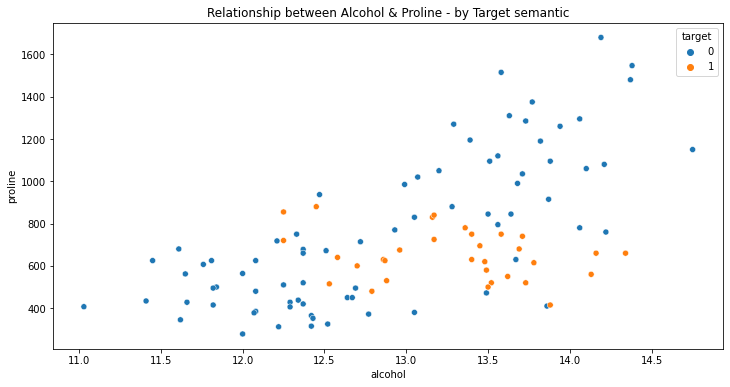

In [15]:
plt.figure(figsize=(12,6))
plt.title('Relationship between Alcohol & Proline - by Target semantic')
sns.scatterplot(x=df['alcohol'], y=df['proline'], hue=df['target']);

Hay relacion entre `alcohol` y `proline`. Los vinos que pertenecen a la categoria 1 tienen un valor bajo de proline

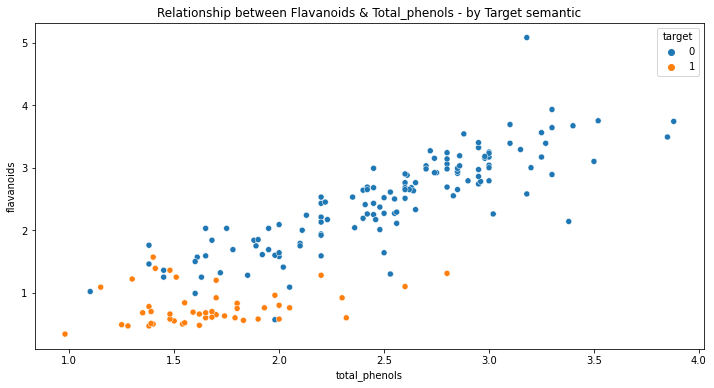

In [16]:
plt.figure(figsize=(12,6))
plt.title('Relationship between Flavanoids & Total_phenols - by Target semantic')
sns.scatterplot(x=df['total_phenols'], y=df['flavanoids'], hue=df['target']);

Hay relacion entre `flavanoids` y `total_phenols`. Los vinos que pertenecen al grupo 1, tienen un menor valor de ambos.

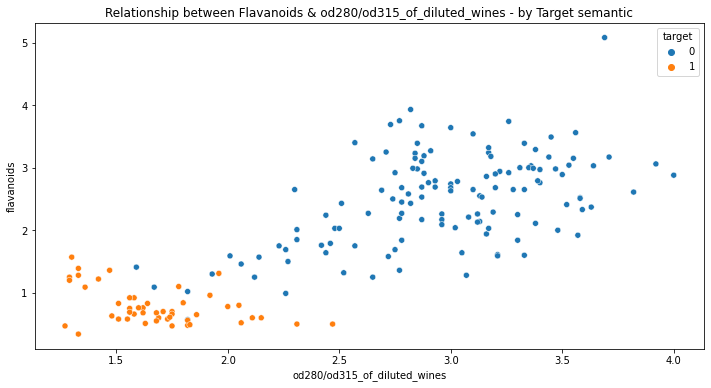

In [17]:
plt.figure(figsize=(12,6))
plt.title('Relationship between Flavanoids & od280/od315_of_diluted_wines - by Target semantic')
sns.scatterplot(x=df['od280/od315_of_diluted_wines'], y=df['flavanoids'], hue=df['target']);

Hay relacion entre `flavanoids` y `od280/od315_of_diluted_wines`. Los vinos que pertenecen al grupo 1, tienen un menor valor de ambos. Mientras que, los vinos que pertenecen a la clase 0, tienen un mayor valor de ambos

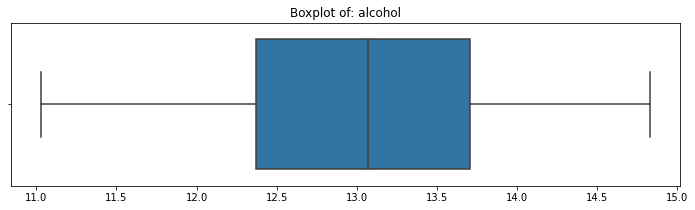

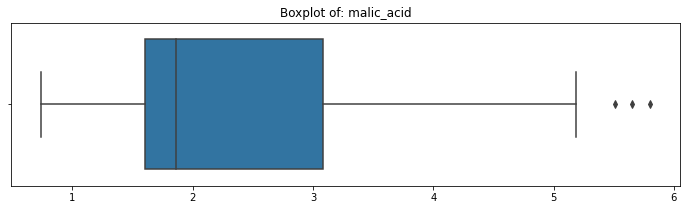

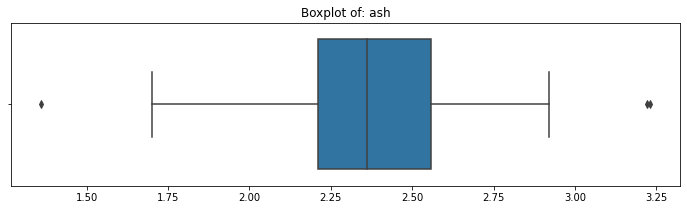

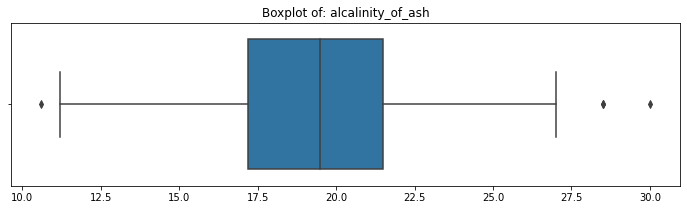

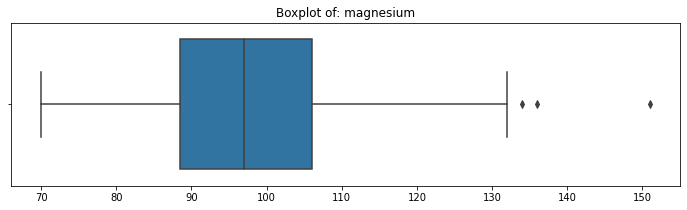

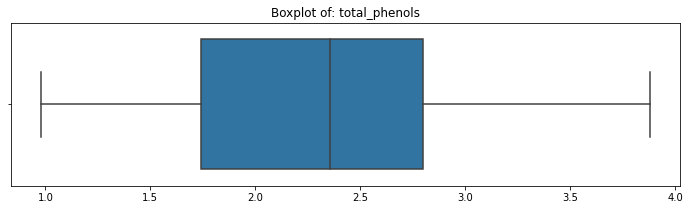

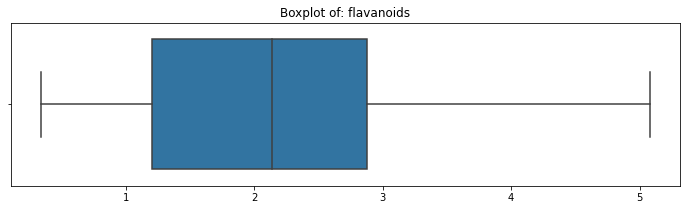

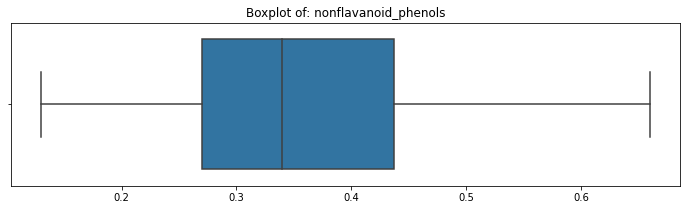

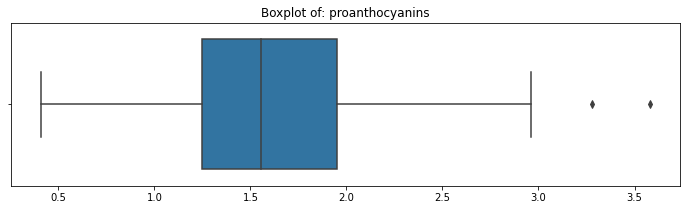

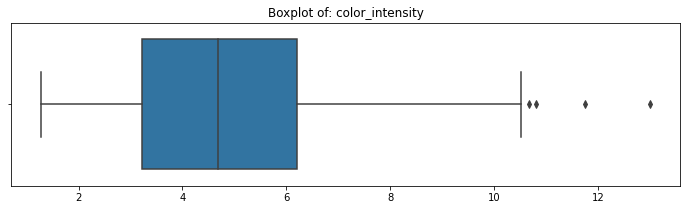

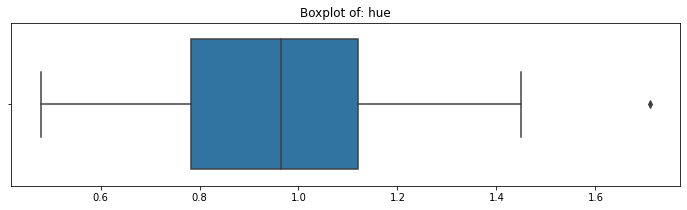

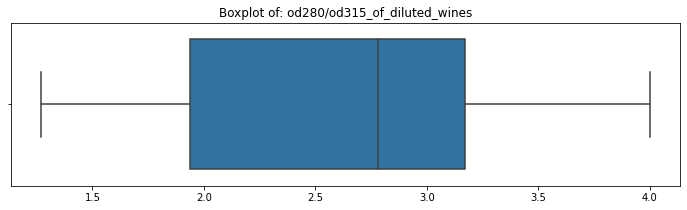

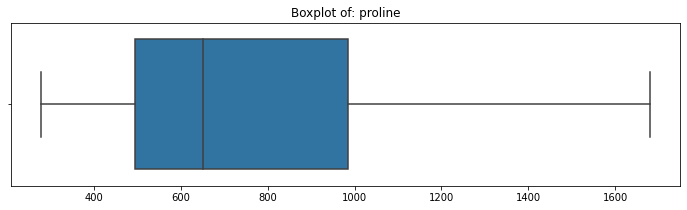

In [ ]:
for i in range(len(df.columns)-1):
  plt.figure(figsize=(12,3))
  plt.title('Boxplot of: {0}'.format(df.columns[i]))
  sns.boxplot(df[df.columns[i]])
  plt.xlabel('')
  plt.show()

Se observa que algunas features presentan outliers o valores atipicos

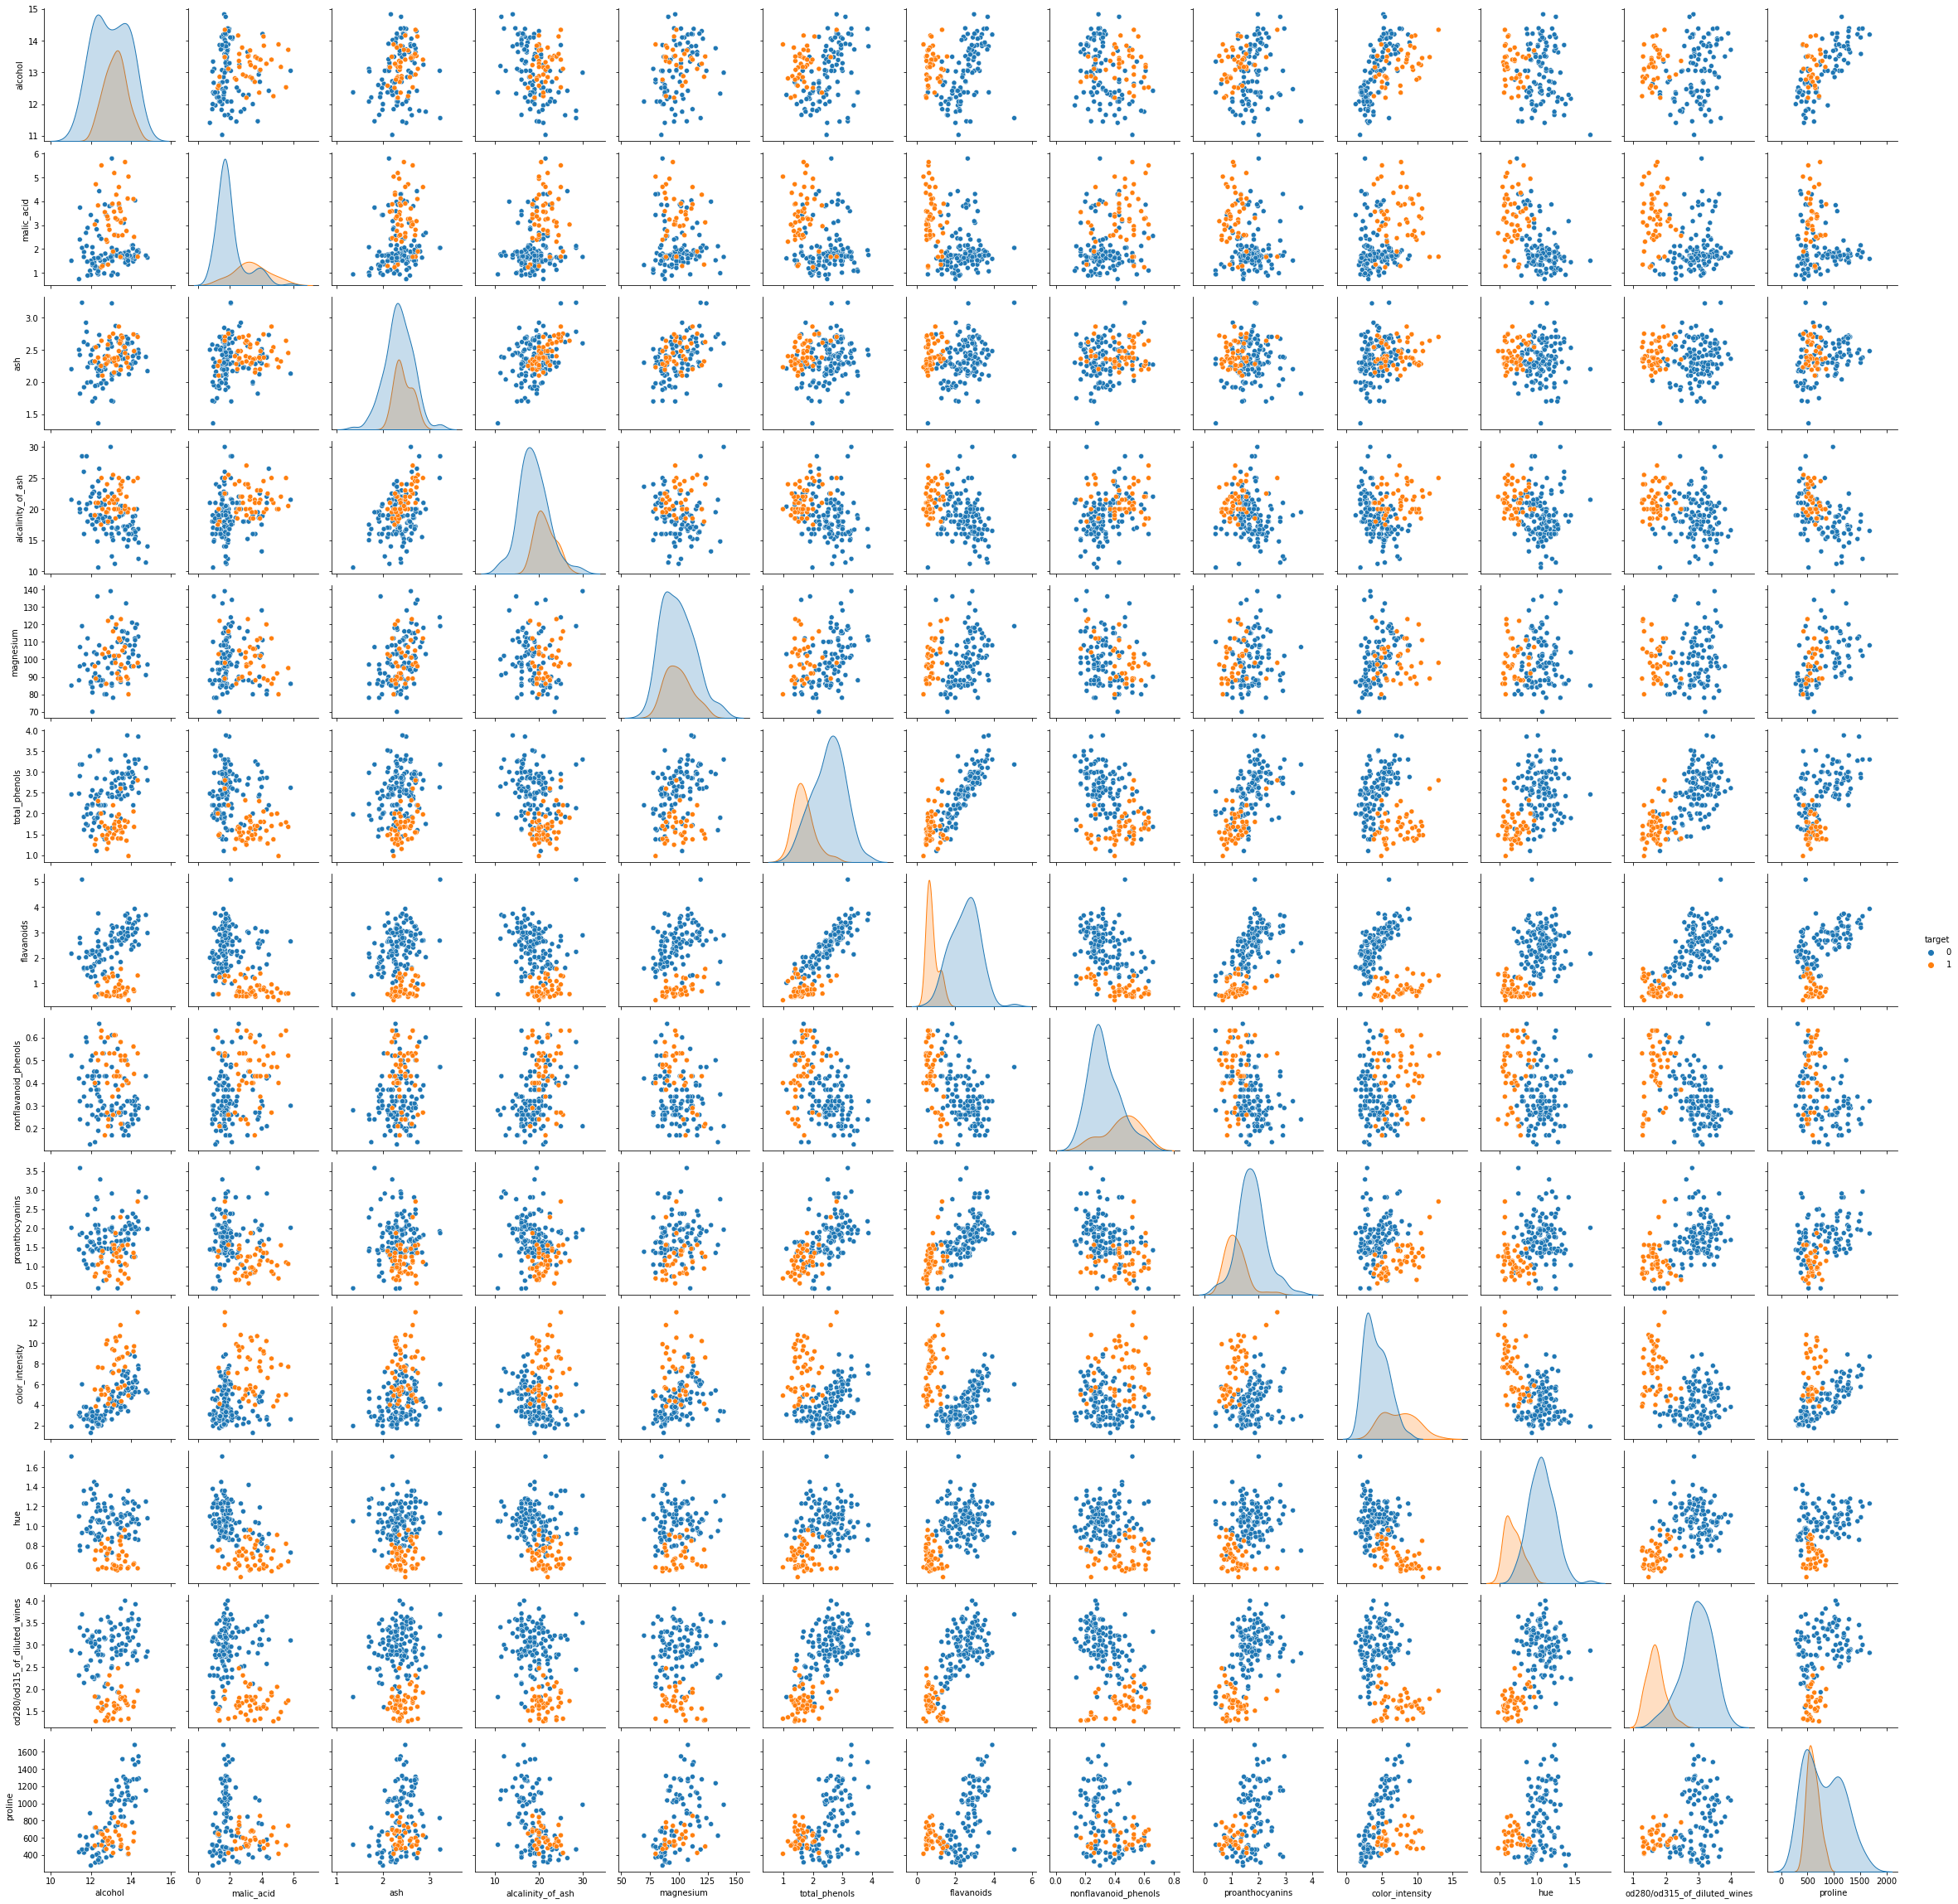

In [ ]:
#Relationship between features by target semantic
sns.pairplot(df, hue='target');

Vemos las relaciones entre las variables y observamos que hay muchas que se relacionan entre ellas. Tambien observamos que las 2 categorias de vinos se diferencian por sus valores en gran parte de las relaciones entre features.

In [ ]:
df[df.target==0].count()

alcohol                         106
malic_acid                      130
ash                             130
alcalinity_of_ash               130
magnesium                       107
total_phenols                   130
flavanoids                      130
nonflavanoid_phenols            130
proanthocyanins                 130
color_intensity                 130
hue                             130
od280/od315_of_diluted_wines    130
proline                         102
target                          130
dtype: int64

In [ ]:
df[df.target==1].count()

alcohol                         37
malic_acid                      48
ash                             48
alcalinity_of_ash               48
magnesium                       40
total_phenols                   48
flavanoids                      48
nonflavanoid_phenols            48
proanthocyanins                 48
color_intensity                 48
hue                             48
od280/od315_of_diluted_wines    48
proline                         39
target                          48
dtype: int64

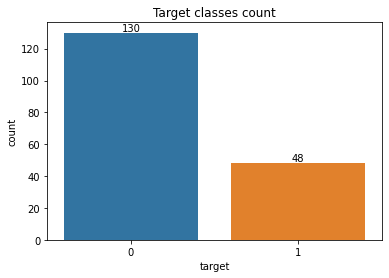

In [ ]:
plt.title('Target classes count')
ax = sns.countplot(df.target);

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

Observamos que nos encontramos ante un dataset desbalanciado

In [ ]:
# Se agrupan los datos en relacion a sus clases
target_group = df.groupby(df.target)

In [ ]:
target_group.get_group(0).describe(percentiles=[.05, .25, .5, .75, .95])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,106.000000,130.000000,130.000000,130.000000,107.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,102.000000,130.0
mean,12.985094,1.968077,2.340462,18.785385,98.691589,2.522692,2.490000,0.330231,1.752385,4.194769,1.058892,2.954385,773.911765,0.0
std,0.906774,0.879968,0.297162,3.400459,14.002972,0.545393,0.737765,0.109087,0.539572,1.625782,0.168690,0.475166,353.291513,0.0
min,11.030000,0.740000,1.360000,10.600000,70.000000,1.100000,0.570000,0.130000,0.410000,1.280000,0.690000,1.590000,278.000000,0.0
5%,11.642500,0.984500,1.889000,14.000000,80.000000,1.604500,1.289000,0.179000,0.986000,2.060000,0.794500,2.087000,342.150000,0.0
25%,12.290000,1.510000,2.170000,16.525000,88.000000,2.147500,2.002500,0.260000,1.422500,2.862500,0.940000,2.732500,463.500000,0.0
50%,13.050000,1.730000,2.320000,18.550000,98.000000,2.560000,2.565000,0.300000,1.705000,3.870000,1.050000,2.980000,697.000000,0.0
75%,13.747500,2.057500,2.527500,20.950000,105.500000,2.937500,2.997500,0.397500,2.005000,5.375000,1.167500,3.300000,1057.500000,0.0
95%,14.352500,3.930500,2.762000,24.775000,125.200000,3.300000,3.604000,0.541000,2.810000,7.132500,1.321000,3.612000,1308.750000,0.0
max,14.830000,5.800000,3.230000,30.000000,151.000000,3.880000,5.080000,0.660000,3.580000,8.900000,1.710000,4.000000,1680.000000,0.0


In [ ]:
target_group.get_group(1).describe(percentiles=[.05, .25, .5, .75, .95])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,37.000000,48.000000,48.000000,48.000000,40.000000,48.000000,48.000000,48.00000,48.000000,48.000000,48.000000,48.000000,39.000000,48.0
mean,13.228919,3.333750,2.437083,21.416667,99.450000,1.678750,0.781458,0.44750,1.153542,7.396250,0.682708,1.683542,621.153846,1.0
std,0.525134,1.087906,0.184690,2.258161,10.772591,0.356971,0.293504,0.12414,0.408836,2.310942,0.114441,0.272111,110.188006,0.0
min,12.250000,1.240000,2.100000,17.500000,80.000000,0.980000,0.340000,0.17000,0.550000,3.850000,0.480000,1.270000,415.000000,1.0
5%,12.432000,1.462000,2.193500,18.500000,86.000000,1.260500,0.473500,0.22700,0.654000,4.187500,0.553500,1.293500,465.500000,1.0
25%,12.850000,2.587500,2.300000,20.000000,90.500000,1.407500,0.580000,0.39750,0.855000,5.437500,0.587500,1.510000,525.000000,1.0
50%,13.270000,3.265000,2.380000,21.000000,97.000000,1.635000,0.685000,0.47000,1.105000,7.550000,0.665000,1.660000,625.000000,1.0
75%,13.580000,3.957500,2.602500,23.000000,106.000000,1.807500,0.920000,0.53000,1.350000,9.225000,0.752500,1.820000,682.500000,1.0
95%,14.136000,5.137500,2.733000,25.000000,120.100000,2.313000,1.342500,0.62300,1.761500,10.758000,0.890000,2.136000,835.500000,1.0
max,14.340000,5.650000,2.860000,27.000000,123.000000,2.800000,1.570000,0.63000,2.700000,13.000000,0.960000,2.470000,855.000000,1.0


Vemos que generalmente las variables tienen un mayor valor para los vinos de clase 0

-----------

# 🔧 3. Manipulación de variables

------------------

In [19]:
df1 = df.copy()
df2 = df.copy()

In [20]:
df1.alcohol.fillna(df1.alcohol.mean(), inplace=True)
df1.magnesium.fillna(df1.magnesium.median(), inplace=True)
df1.proline.fillna(df1.proline.median(), inplace=True)

Para el primer dataframe se completaron los valores nulos de `alcohol` mediante su media. Los valores nulos de las variables `magnesium` y `proline` se completaron con la mediana. Se realizo de esta manera porque alcohol no tenia valores atipicos, mientras que las otras dos variables si

In [21]:
df1.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [23]:
df2.drop(columns=['alcohol', 'magnesium', 'proline'], inplace=True)

Para el segundo dataframe, se eliminaron directamente las variables con valores faltantes

In [24]:
df2.isna().sum()

malic_acid                      0
ash                             0
alcalinity_of_ash               0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
target                          0
dtype: int64

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   malic_acid                    178 non-null    float64
 1   ash                           178 non-null    float64
 2   alcalinity_of_ash             178 non-null    float64
 3   total_phenols                 178 non-null    float64
 4   flavanoids                    178 non-null    float64
 5   nonflavanoid_phenols          178 non-null    float64
 6   proanthocyanins               178 non-null    float64
 7   color_intensity               178 non-null    float64
 8   hue                           178 non-null    float64
 9   od280/od315_of_diluted_wines  178 non-null    float64
 10  target                        178 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 15.4 KB


In [26]:
df1_without_outliers = df1.copy()
df2_without_outliers = df2.copy()

In [27]:
# Funcion para limpiar los valores atipicos o outliers
def clean_outlier(data):
  z_scores = zscore(data)
  abs_z = np.abs(z_scores)
  filtered_by_rows = (abs_z < 3).all(axis=1)
  new_df = data[filtered_by_rows]
  return new_df

In [28]:
df1_without_outliers = clean_outlier(df1)
df2_without_outliers = clean_outlier(df2)

Se crearon 2 dataframes a partir de los dos primeros, pero se les limpio los outliers o valores atipicos para comprobar su incidencia posteriormente en los modelos que se desarrollaran

In [29]:
df1_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       167 non-null    float64
 1   malic_acid                    167 non-null    float64
 2   ash                           167 non-null    float64
 3   alcalinity_of_ash             167 non-null    float64
 4   magnesium                     167 non-null    float64
 5   total_phenols                 167 non-null    float64
 6   flavanoids                    167 non-null    float64
 7   nonflavanoid_phenols          167 non-null    float64
 8   proanthocyanins               167 non-null    float64
 9   color_intensity               167 non-null    float64
 10  hue                           167 non-null    float64
 11  od280/od315_of_diluted_wines  167 non-null    float64
 12  proline                       167 non-null    float64
 13  targe

In [30]:
df2_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 177
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   malic_acid                    170 non-null    float64
 1   ash                           170 non-null    float64
 2   alcalinity_of_ash             170 non-null    float64
 3   total_phenols                 170 non-null    float64
 4   flavanoids                    170 non-null    float64
 5   nonflavanoid_phenols          170 non-null    float64
 6   proanthocyanins               170 non-null    float64
 7   color_intensity               170 non-null    float64
 8   hue                           170 non-null    float64
 9   od280/od315_of_diluted_wines  170 non-null    float64
 10  target                        170 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 15.9 KB


In [31]:
y1, _ = np.asarray(df1.target), df1.drop(columns=['target'], inplace=True)
y2, _ = np.asarray(df2.target), df2.drop(columns=['target'], inplace=True)
y1_out, _ = np.asarray(df1_without_outliers.target), df1_without_outliers.drop(columns=['target'], inplace=True)
y2_out, _ = np.asarray(df2_without_outliers.target), df2_without_outliers.drop(columns=['target'], inplace=True)

Se guarda la variable target de cada dataframe como un array de numpy y se lo elimina de los mismos.

In [32]:
scaler = MinMaxScaler()

In [33]:
df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)
df1_without_outliers = pd.DataFrame(scaler.fit_transform(df1_without_outliers), columns=df1_without_outliers.columns)
df2_without_outliers = pd.DataFrame(scaler.fit_transform(df2_without_outliers), columns=df2_without_outliers.columns)

Se escalan las features para obtener valores comprendidos entre 0 y 1

In [34]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df1, y1, test_size=.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(df2, y2, test_size=.2, random_state=42, stratify=y2)
X1out_train, X1out_test, y1out_train, y1out_test = train_test_split(df1_without_outliers, y1_out, test_size=.2, random_state=42, stratify=y1_out)
X2out_train, X2out_test, y2out_train, y2out_test = train_test_split(df2_without_outliers, y2_out, test_size=.2, random_state=42, stratify=y2_out)

Se realiza un split de train y test con un 20% de los datos para el conjunto de test. Se utiliza como estrategia el target

-------

# 🎯 4. Modelo para Clasificar

-----------

In [35]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

Se hace un cross-validation de 10 splits y una mezcla de los cortes. Se va a usar luego en el random search

In [36]:
param = {
    'learning_rate': np.linspace(0.001, 0.5, 5), 
    'n_estimators': [1, 2], 
    'booster': ['gbtree', 'gblinear', 'dart'], 
    'min_child_weight': np.arange(25, 30, 1), 
        }

LogLoss = make_scorer(log_loss, greater_is_better=False)

Se pasan los hiperparametros en un diccionario para que luego el random search busque entre ellos de manera aleatoria. Tambien, se hace un scorer a partir de la metrica log_loss

In [37]:
xgbr1 = XGBRegressor(max_depth=1, n_jobs=-1, scale_pos_weight=2.7, eval_metric='logloss', objective='binary:logistic')
xgbr2 = XGBRegressor(max_depth=1, n_jobs=-1, scale_pos_weight=2.7, eval_metric='logloss', objective='binary:logistic')
xgbr3 = XGBRegressor(max_depth=1, n_jobs=-1, scale_pos_weight=2.7, eval_metric='logloss', objective='binary:logistic')
xgbr4 = XGBRegressor(max_depth=1, n_jobs=-1, scale_pos_weight=2.7, eval_metric='logloss', objective='binary:logistic')

### XGBRegressor
XGBoost es un algoritmo de aprendizaje automático basado en un conjunto de árboles de decisiones que utiliza el aumento de gradiente. Se puede emplear para resolver problemas de regresión y clasificación.

Hacemos 4 regresores de XGBoost y establecemos como valor 2.7 al scale_pos_weight que nos sera de utilidad para el desempeño del modelo en el dataset desbalanceado. 
2.7 corresponde a la cantidad de categorias 0 / cantidad de categorias 1.

In [38]:
random_search1 = RandomizedSearchCV(xgbr1, param_distributions=param, n_iter=50, n_jobs=-1, cv=cv, random_state=42, return_train_score=True, scoring=LogLoss, refit=True)
random_search2 = RandomizedSearchCV(xgbr2, param_distributions=param, n_iter=50, n_jobs=-1, cv=cv, random_state=42, return_train_score=True, scoring=LogLoss, refit=True)
random_search3 = RandomizedSearchCV(xgbr3, param_distributions=param, n_iter=50, n_jobs=-1, cv=cv, random_state=42, return_train_score=True, scoring=LogLoss, refit=True)
random_search4 = RandomizedSearchCV(xgbr4, param_distributions=param, n_iter=50, n_jobs=-1, cv=cv, random_state=42, return_train_score=True, scoring=LogLoss, refit=True)

Se emplean 4 random search para buscar de manera aleatoria los mejores hiperparametros de cada modelo. Se realiza un cross validation de 10 splits, 50 iteraciones y se reentrena con los mejores hiperparametros para luego entrenar el modelo.

In [39]:
# Funcion para pasar el array de probabilidades a binario
def binary_classification(prediction, threshold):
  predict = np.where(prediction<threshold, 0, 1)
  return predict

In [40]:
%%time

model1 = random_search1.fit(X1_train, y1_train)
model2 = random_search2.fit(X2_train, y2_train)
model3 = random_search3.fit(X1out_train, y1out_train)
model4 = random_search4.fit(X2out_train, y2out_train)

CPU times: user 2.85 s, sys: 88.3 ms, total: 2.94 s
Wall time: 14.5 s


Se entrenan o fittean los 4 modelos y se mide el tiempo total de los entrenamientos

In [41]:
y1_pred = binary_classification(model1.predict(X1_test), 0.5)
y2_pred = binary_classification(model2.predict(X2_test), 0.5)
y1out_pred = binary_classification(model3.predict(X1out_test), 0.5)
y2out_pred = binary_classification(model4.predict(X2out_test), 0.5)

Se realizan las predicciones, se transforman las mismas en 0 o 1's y se guardan en variables.

In [42]:
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.90      0.90      0.90        10

    accuracy                           0.94        36
   macro avg       0.93      0.93      0.93        36
weighted avg       0.94      0.94      0.94        36



In [43]:
print(classification_report(y2_test, y2_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.90      0.90      0.90        10

    accuracy                           0.94        36
   macro avg       0.93      0.93      0.93        36
weighted avg       0.94      0.94      0.94        36



In [44]:
print(classification_report(y1out_test, y1out_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        10

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



In [45]:
print(classification_report(y2out_test, y2out_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.90      1.00      0.95         9

    accuracy                           0.97        34
   macro avg       0.95      0.98      0.96        34
weighted avg       0.97      0.97      0.97        34



Mediante el classification report podemos conocer el desempeño de los modelos. Con la precision y el recall que tuvieron para clasificar cada clase

In [61]:
random_search3.best_estimator_

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
             gamma=0, importance_type='gain', learning_rate=0.37525,
             max_delta_step=0, max_depth=1, min_child_weight=27, missing=None,
             n_estimators=2, n_jobs=-1, nthread=None,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=2.7, seed=None, silent=None,
             subsample=1, verbosity=1)

In [62]:
random_search3.best_score_

-0.6514380904999408

------

### Conclusion
Podemos ver que el modelo que tuvo mejor desempeño fue el 3. El cual fue realizado en el dataset sin outliers y con los valores faltantes completados por su media y mediana. Tambien, es necesario en el futuro utilizar otro conjuntos de datos de test para descartar que el modelo este realizando un overfitting

----------

In [46]:
# Se guarda el nuevo dataset escalado y sin outliers o valores atipicos
# df1_without_outliers.to_csv('Dataset_cleaned')

In [47]:
# Se guarda el modelo random_search3 
with open('random_search3.pk', 'wb') as fp:
    pickle.dump(random_search3, fp)